In [69]:
import pandas as pd
import seaborn as sns
from scipy import stats

## data prep
from sklearn.model_selection import train_test_split
import missingno as msno 

## modeling
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor



## evaluation
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

## visualization 
from plotnine import *
from plotly.offline import iplot
import plotly_express as px


In [70]:
df = pd.read_csv('../washington-post-election-night-model/data/county_data.csv')

In [71]:
## change fips to string
df['fips'] = df['fips'].astype(str)
df['fips'] = df['fips'].str.zfill(5)

In [72]:
## features we will mainly use
features = [
    #'fips',
    'female',
    'male',
    'white',
    'black',
    'aapi',
    'hispanic',
    'other_race_alone',
    'median_income',
    'bachelor_or_higher',
    'age_le_30',
    'age_ge_30_le_45',
    'age_ge_45_le_65',
    'age_ge_65',
    'total_votes_2016'
]

# Target variable

In [73]:
df['vote_change']=(df['total_votes_2020']-df['total_votes_2016'])


# Data Prep

##### Explore which counties are blank

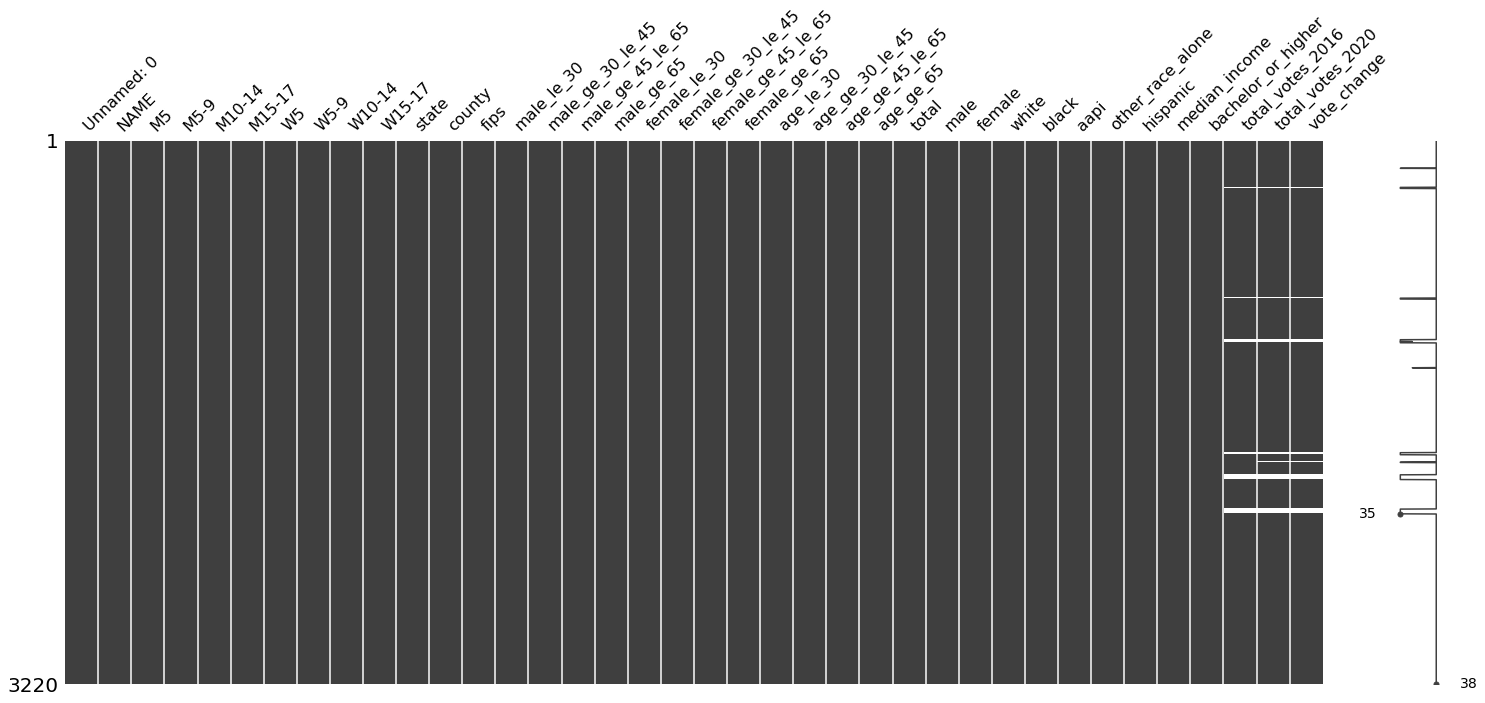

In [74]:
msno.matrix(df) 

In [75]:
df = df.dropna()


##### Train test split

In [76]:
X = df[features]
y = df['total_votes_2020']

In [77]:
X = df[features]
y = df['total_votes_2020']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

# Parametric, OLS

In [10]:
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

LinearRegression()

In [11]:
reg_ypred = reg.predict(Xtest)
reg_ytrue = ytest

r2_score(reg_ytrue, reg_ypred)

0.9803234769785992

##### Evaluate how close the guesses are 

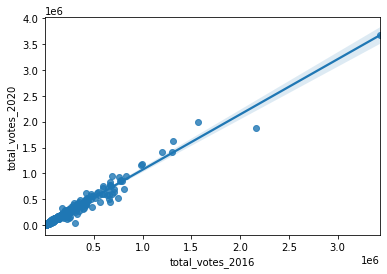

In [12]:
sns.regplot(x='total_votes_2016', y='total_votes_2020', data=df)

##### Evaluate percentage off, so difference of predicted vs actual 

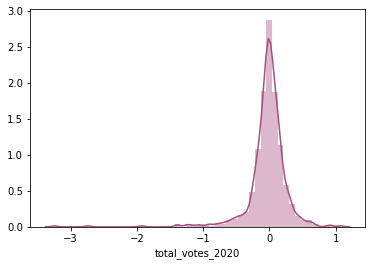

In [13]:
test=(reg_ypred - reg_ytrue)/reg_ytrue
sns.distplot(test, color = "#a54f7e")

In [14]:
#OLS prediction interval 

def ols_quantile(m, X, q):
  # m: OLS statsmodels model.
  # X: X matrix.
  # q: Quantile.
  mean_pred = m.predict(X)
  se = np.sqrt(m.scale)
  return mean_pred + norm.ppf(q) * se

##### Generating prediction intervals and then counting counties in interval vs. out of interval.

We can calculate the percentage of the time the actual value is within the range, but this can be easily optimized by making the interval very wide. Therefore, we also want a metric that takes into account how far away the predictions are from the actual value, such as absolute error.


In the notebook, I’ve provided a function that calculates the absolute error for the lower, mid, and upper predictions and then averages the upper and lower error for an “Interval” absolute error. We can do this for each data point and then plot a boxplot of the errors (the percent in bounds is in the title):

https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

In [15]:
# Set lower and upper quantile
LOWER_ALPHA = 0.15
UPPER_ALPHA = 0.85

N_ESTIMATORS = 100
MAX_DEPTH = 5

# Each model has to be separate

lower_model = GradientBoostingRegressor(
    loss="quantile", alpha=LOWER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)
# The mid model will use the default
mid_model = GradientBoostingRegressor(loss="ls", n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)

upper_model = GradientBoostingRegressor(
    loss="quantile", alpha=UPPER_ALPHA, n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH
)

In [16]:
lower_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.15, loss='quantile', max_depth=5)

In [17]:
mid_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(max_depth=5)

In [18]:
upper_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(alpha=0.85, loss='quantile', max_depth=5)

In [19]:
predictions = pd.DataFrame(ytest)
predictions['lower'] = lower_model.predict(Xtest)
predictions['mid'] = mid_model.predict(Xtest)
predictions['upper'] = upper_model.predict(Xtest)

#assert (predictions['upper'] > predictions['lower']).all()

predictions.tail()

,total_votes_2020,lower,mid,upper
2569,16819.0,16132.937844,17335.962738,19976.724131
2399,930.0,812.077858,1053.145019,1243.656510
2468,36795.0,31824.326550,36314.315171,37594.695891
1301,17675.0,16051.106288,16538.318849,16143.585159
2911,1165.0,1174.141838,1293.828359,2234.414654


In [20]:
def calculate_error(df):
    """
    Calculate the absolute error associated with prediction intervals
    
    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe
    
    """
    df['absolute_error_lower'] = (df['lower'] - df['total_votes_2020']).abs()
    df['absolute_error_upper'] = (df['upper'] - df['total_votes_2020']).abs()
    
    df['absolute_error_interval'] = (df['absolute_error_lower'] + df['absolute_error_upper']) / 2
    df['absolute_error_mid'] = (df['mid'] - df['total_votes_2020']).abs()
    
    df['in_bounds'] = df['total_votes_2020'].between(left=df['lower'], right=df['upper'])
    
    
    df['percent_error_lower'] = (df['absolute_error_lower']/df['total_votes_2020'])*100
    df['percent_error_upper'] = (df['absolute_error_upper']/df['total_votes_2020'])*100
    df['percent_error_interval'] = (df['absolute_error_interval']/df['total_votes_2020'])*100
    df['percent_error_mid'] = (df['absolute_error_mid']/df['total_votes_2020'])*100
    
    return df

In [21]:
predictions = calculate_error(predictions)



In [22]:
## add line mean percent error on each interval

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



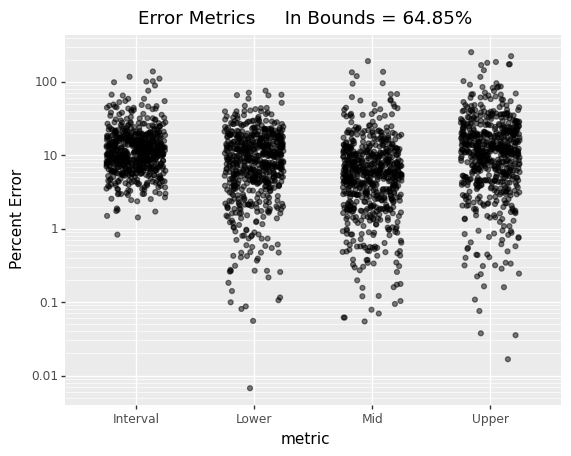

<ggplot: (154769193485)>

In [23]:
percent_in_bounds = predictions['in_bounds'].mean() * 100
metrics_to_plot = predictions[[col for col in predictions if 'percent_error' in col]]

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

(ggplot(dat,aes(x="metric",y="Percent Error")) +
  geom_jitter(width = .25,alpha=.5,show_legend=False) +
  scale_y_log10() +
  labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%"))

# Non-parametric, KNN

In [24]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(Xtrain, ytrain)


KNeighborsRegressor(n_neighbors=1)

In [25]:
# split the data into a train and validation sets 
#X1, X2, y1, y2 = train_test_split(Xtrain, ytrain, test_size=0.5) 

# base_model can be any regression 
#modelbase_mode.fit(X1, y1) 
base_prediction = knn.predict(Xtest) 

#compute the RMSE value 
error = mean_squared_error(base_prediction, ytest) ** 0.5 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest) 
st_dev = error

In [26]:
error_model = LinearRegression()

https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb

In [27]:
# split the data in train a validation set
#X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)

# base_model can be any regression model 
knn.fit(Xtrain, ytrain) 
base_prediction = knn.predict(Xtest) 

# compute the prediction error vector on the validation set 
validation_error = (base_prediction - ytest) ** 2 
error_model.fit(Xtest, validation_error) 

# compute the mean and standard deviation of the distribution 
mean = knn.predict(Xtest)
error = error_model.predict(Xtest)

In [28]:
# mean plus or minus (st_dv)*tstat for prediction%
# https://otexts.com/fpp2/prediction-intervals.html

## evaluate error model, find best error model

In [29]:
knnPredictions = pd.DataFrame(ytest)
knnPredictions['std'] = error
knnPredictions['std'] = knnPredictions['std'].abs()**0.5

In [30]:
from scipy.stats import t


## sample size
N = len(knnPredictions)

## degrees of freedom
df = 2*N - 2

t = t.ppf(0.95, df)

In [31]:
knnPredictions['mid'] = knn.predict(Xtest)
knnPredictions['lower'] = knnPredictions['mid'] - (knnPredictions['std']*t)
knnPredictions['upper'] = knnPredictions['mid'] + (knnPredictions['std']*t)

#assert (predictions['upper'] > predictions['lower']).all()

knnPredictions.tail()

,total_votes_2020,std,mid,lower,upper
2569,16819.0,27697.099269,16348.0,-29243.625655,61939.625655
2399,930.0,82054.541325,754.0,-134314.293434,135822.293434
2468,36795.0,112469.440573,41560.0,-143573.633755,226693.633755
1301,17675.0,67473.180076,14313.0,-96753.214475,125379.214475
2911,1165.0,25440.309506,1982.0,-39894.770425,43858.770425


In [32]:
knnPredictions = calculate_error(knnPredictions)

C:\Users\madel\anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



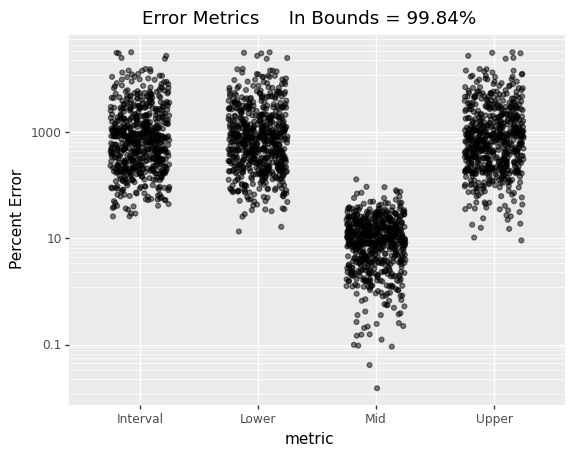

<ggplot: (154769976360)>

In [33]:
percent_in_bounds = knnPredictions['in_bounds'].mean() * 100
metrics_to_plot = knnPredictions[[col for col in knnPredictions if 'percent_error' in col]]

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

(ggplot(dat,aes(x="metric",y="Percent Error")) +
  geom_jitter(width = .25,alpha=.5,show_legend=False) +
  scale_y_log10() +
  labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%"))

# Conformalized quantile regression

https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3

https://github.com/yromano/cqr/blob/master/cqr_synthetic_data_example_1.ipynb

https://github.com/yromano/cqr/blob/master/cqr_synthetic_data_example_2.ipynb

##### Functions

In [34]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np
np.warnings.filterwarnings('ignore')


split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

%matplotlib inline
np.random.seed(1)

# desired miscoverage error
alpha = 0.1
# low and high target quantiles
quantiles = [5, 95]

# maximal number of testpoints to plot
max_show = 1000

# save figures?
save_figures = False

# parameters of random forests
n_estimators = 100
min_samples_leaf = 40
max_features = 1 # 1D signal
random_state = 0

##### The star of the show

In [56]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc

In [45]:
#from statsmodels.regression.quantile_regression import QuantReg

x = np.array([1, 2, 3, 4, 5])
y = np.array([5, 6, 7, 8, 9])

qr=helper.QuantReg(endog = x, exog = y)

In [46]:
params = dict()
params["CV"] = True
params["coverage_factor"] = 0.9
params["test_ratio"] = 0.1
params["range_vals"] = 10
params["num_vals"] = 4
params["random_state"] = random_state
quantiles = [5, 95]

In [50]:
qr= helper.QuantReg(x,y, params = params)

In [57]:
qr.optimize()

AttributeError: 'QuantReg' object has no attribute 'optimize'

##### linear quantile regression

In [ ]:
# define quantile random forests (QRF) parameters
params = dict()
params["CV"] = True
params["coverage_factor"] = 0.9
params["test_ratio"] = 0.1
params["range_vals"] = 10
params["num_vals"] = 4
params["random_state"] = random_state
quantiles = [5, 95]

helper.QuantileLinearRegressorAdapter(
                                      model=None,
                                      #fit_params=None,
                                      #quantiles=quantiles,
                                      params=params
                                     )



##### quantile random forrest regression

In [58]:
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = random_state
params_qforest["range_vals"] = 10
params_qforest["num_vals"] = 4

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)



##### conformal stuff

In [59]:
# number of training examples
n_train = len(Xtrain)

In [60]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

In [61]:
Xtrain_idx_train = Xtrain.reindex(index = idx_train).dropna().to_numpy()
ytrain_idx_train = ytrain.reindex(index = idx_train).dropna().to_numpy()

Xtrain_idx_cal = Xtrain.reindex(index = idx_cal).dropna().to_numpy()
ytrain_idx_cal = ytrain.reindex(index = idx_cal).dropna().to_numpy()

In [62]:
# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)


# fit the conditional quantile regression to the proper training data
icp.fit(Xtrain_idx_train, ytrain_idx_train)

# compute the absolute errors on calibration data
icp.calibrate(Xtrain_idx_cal, ytrain_idx_cal)

In [63]:
Xtestnp =Xtest.to_numpy()

# produce predictions for the test set, with confidence equal to significance
cqrPredictions = icp.predict(Xtestnp, significance=alpha)


In [64]:
cqrPredictions

array([[  4430.6715609 ,  10543.94770555],
       [  6046.10957919,  12381.5753546 ],
       [130766.42663742, 514012.59112489],
       ...,
       [ 25417.31331983,  69676.88595207],
       [ 11320.16990677,  22368.42413843],
       [  1846.07273078,   7305.61104249]])

In [78]:
#y_lower = predictions[:,0]
#y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred = quantile_estimator.predict(Xtest)

In [79]:
#cqrPredictions = pd.DataFrame(cqrPredictions, columns = ['lower', 'upper'])
cqrPredictions = pd.DataFrame(pred, columns = ['lower', 'upper'])

##### evaluation

In [80]:
cqrPredictions['mid'] = (cqrPredictions['upper']+cqrPredictions['lower'])/2
cqrPredictions['total_votes_2020'] = y


In [81]:
cqrPredictions = calculate_error(cqrPredictions)

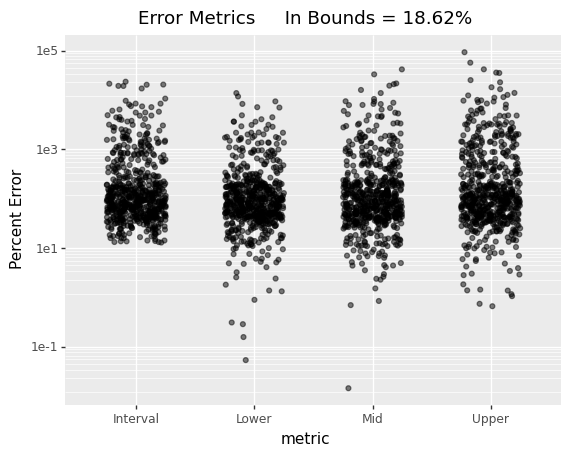

<ggplot: (154773834638)>

In [82]:
percent_in_bounds = cqrPredictions['in_bounds'].mean() * 100
metrics_to_plot = cqrPredictions[[col for col in knnPredictions if 'percent_error' in col]]

# Rename the columns
metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

dat = metrics_to_plot.melt(var_name="metric", value_name='Percent Error')

(ggplot(dat,aes(x="metric",y="Percent Error")) +
  geom_jitter(width = .25,alpha=.5,show_legend=False) +
  scale_y_log10() +
  labs(title=f"Error Metrics     In Bounds = {percent_in_bounds:.2f}%"))

##### graphing

In [ ]:
x=Xtest.to_numpy()
y=ytest.to_numpy()
y_u=y_upper
y_l=y_lower
pred=pred
shade_color=cqr_color
method_name="CQR:"
title="CQR Random Forests (quantile regression)"


x_ = x[:max_show]
y_ = y[:max_show]
if y_u is not None:
    y_u_ = y_u[:max_show]
if y_l is not None:
    y_l_ = y_l[:max_show]
if pred is not None:
    pred_ = pred[:max_show]


In [ ]:

fig = plt.figure()
inds = np.argsort(np.squeeze(x_))

plt.plot(x_, y_, 'k.', alpha=.2, markersize=10,
         fillstyle='none', label=u'Observations')

if (y_u is not None) and (y_l is not None):
    plt.fill(np.concatenate([x_, x_[::-1]]),
             np.concatenate([y_u_, y_l_[::-1]]),
             alpha=.3, fc=shade_color, ec='None',
             label = method_name + ' prediction interval')
    
    
if pred is not None:
    if pred_.ndim == 2:
        plt.plot(x_, pred_, 'k', lw=2, alpha=0.9,
                 label=u'Predicted low and high quantiles')
        plt.plot(x_, pred_, 'k', lw=2, alpha=0.9)
    else:
        plt.plot(x_, pred_, 'k--', lw=2, alpha=0.9,
                 label=u'Predicted value')
        
        
#plt.ylim([-2.5, 7])
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend(loc='upper right')
plt.title(title)
if save_figures and (filename is not None):
    plt.savefig(filename, bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [ ]:
q = .9

mod = smf.quantreg('total_votes_2020 ~ total_votes_2016', yo)
res = mod.fit(q=q)
print(res.summary())

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [ ]:
from statsmodels.regression.quantile_regression import QuantReg

ols = QuantReg(ytrain, Xtrain)
res = ols.fit(q = 0.5)
#res.predict(Xtest)

In [ ]:
res.predict(Xtest)

In [ ]:
ytest

In [ ]:
# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(ols, QuantileRegErrFunc())


# build the split CQR object
icp = IcpRegressor(nc)


# fit the conditional quantile regression to the proper training data
icp.fit(q)

# compute the absolute errors on calibration data
#icp.calibrate(Xtrain_idx_cal, ytrain_idx_cal)
